# Liquid Democracy
Trying to implement an ensemble methodology for voting based on the [Liquid Democracy](http://procaccia.info/papers/liquid.pdf) paper.

The important bits i see in this process is:
- the *competence level* should be an estimate based on train/valid accuracy or distance to each new sample (or a mix of both)
- the cap(n) is constant in  our case? This should be optimized?

In [1]:
from __future__ import print_function

from pprint import pprint
from time import time
import logging
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# #############################################################################
# Load some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories)
print("%d documents" % len(data.filenames))
print("%d categories" % len(data.target_names))
print()

#############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__max_iter': (10, 50, 80, 150),
}

X = data.data
y = data.target

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

#     print("Performing grid search...")
#     print("pipeline:", [name for name, _ in pipeline.steps])
#     print("parameters:")
#     pprint(parameters)
#     t0 = time()
#     # grid_search.fit(data.data, data.target)
#     grid_search.fit(X, y)
#     print("done in %0.3fs" % (time() - t0))
#     print()

#     print("Best score: %0.3f" % grid_search.best_score_)
#     print("Best parameters set:")
#     best_parameters = grid_search.best_estimator_.get_params()
#     for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

Automatically created module for IPython interactive environment
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories



In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=42, test_size=0.3)
# X_valid, X_test, y_valid, y_test= train_test_split(X_test, y_test, 
#                                                    random_state=42, test_size=0.5)
grid_search.fit(X_train, y_train)
cur_mod = grid_search.best_estimator_
pred = cur_mod.predict(X_test)
print(accuracy_score(y_test, pred))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    6.0s finished


0.937984496124031


In [24]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer

pip = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())])

tr = pip.fit_transform(X_train, y_train)
mi = mutual_info_classif(tr, y_train)
print(len(mi),tr.shape[1])
mi = mi/sum(mi)
#tr_valid = pip.transform(X_valid)
tr_test = pip.transform(X_test)

15443 15443


In [80]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
clf = RandomForestClassifier(n_estimators=100 ,random_state=42, min_samples_leaf=2)
clf.fit(tr, y_train)
pred = clf.predict(tr_test)
print(accuracy_score(y_test, pred))

0.8914728682170543


In [79]:
for est in clf.estimators_:
    print(est.predict_proba(tr_test)[0,0])

1.0
1.0
0.28169014084507044
1.0
0.9032258064516129
0.9411764705882353
1.0
0.6666666666666666
0.6666666666666666
1.0
0.8333333333333334
1.0
0.0
1.0
0.5714285714285714
0.1282051282051282
0.9090909090909091
0.6666666666666666
0.2222222222222222
1.0
0.6153846153846154
0.7272727272727273
0.375
0.2894736842105263
0.8333333333333334
0.5454545454545454
1.0
0.21428571428571427
0.6666666666666666
0.6923076923076923
0.6363636363636364
0.3466666666666667
0.0967741935483871
1.0
0.6363636363636364
0.8666666666666667
0.8214285714285714
0.0
0.85
0.0
1.0
0.6666666666666666
1.0
1.0
0.8333333333333334
0.0
1.0
0.717948717948718
1.0
0.0
0.6666666666666666
1.0
0.0
0.76
0.0
1.0
1.0
1.0
1.0
0.92
0.0
0.0
1.0
1.0
0.8
0.8571428571428571
0.6666666666666666
0.9333333333333333
0.2857142857142857
1.0
1.0
1.0
1.0
0.4731182795698925
0.8461538461538461
1.0
1.0
1.0
1.0
0.0
0.6666666666666666
1.0
0.6451612903225806
0.8113207547169812
0.9375
0.6666666666666666
1.0
0.75
0.8666666666666667
1.0
1.0
1.0
1.0
0.6
0.0
1.0
0.9
1.

In [26]:
k = np.copy(competence)
alpha = 0.5
print(np.where(k - k[0]-alpha>0))
print(k[11], k[0])
if np.where(k - k[0]-alpha>0)[0]:
    print('lala')

NameError: name 'competence' is not defined

In [ ]:
from collections import defaultdict
competence = []
for est in clf.estimators_:
    competence.append(est.score(tr_valid, y_valid))
alpha = 0.2
approves = {}
approved_by = {}
approved_by_length = {}
for i, sc_i in enumerate(competence):
    k = np.copy(competence)
    approves[i] = np.where(k - sc_i - alpha>0)[0].tolist()
    approved_by[i] = np.where(k - sc_i + alpha<0)[0].tolist()
    approved_by_length[i] = len(approved_by[i])
import operator
sorted_approved = sorted(approved_by_length.items(), key=operator.itemgetter(1))[::-1]

    


In [150]:
cap = int(len(competence)*0.2)
cap_per_est = {}
for i in xrange(len(competence)):
    cap_per_est[i] = cap
delegated = {}
poss_nodes = set([i for i in xrange(len(competence))])
for est_id, _ in sorted_approved:
    print(est_id)
    to_deleg = []
    poss_deleg = list(poss_nodes.intersection(approved_by[est_id]))
    if len(poss_deleg) <= cap_per_est[est_id] - 1:
        to_deleg = poss_deleg
    else:
        to_deleg = np.random.choice(poss_deleg, cap_per_est[est_id] - 1).tolist()
    to_deleg = to_deleg + [est_id]
    cap_per_est[est_id] -= len(to_deleg)
    poss_nodes = poss_nodes.difference(to_deleg)
    delegated[est_id] = to_deleg
    if len(poss_nodes) == 0:
        break
delegated

40
11
95
99
93
16
77
71
49
45
31
26
19
18
92
75
61
58
47
38
30
98
97
96
94
91
90
89
88
87
86
85
84
83
82
81
80
79
78
76
74
73
72
70
69
68
67
66
65
64
63
62
60
59
57
56
55
54
53
52
51
50
48
46
44
43
42
41
39
37
36
35
34
33
32
29
28
27
25
24
23
22
21
20
17
15
14
13
12
10
9
8
7
6
5
4
3
2
1
0


{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 9: [9],
 10: [10],
 11: [11],
 12: [12],
 13: [13],
 14: [14],
 15: [15],
 16: [16],
 17: [17],
 18: [18],
 19: [19],
 20: [20],
 21: [21],
 22: [22],
 23: [23],
 24: [24],
 25: [25],
 26: [26],
 27: [27],
 28: [28],
 29: [29],
 30: [30],
 31: [31],
 32: [32],
 33: [33],
 34: [34],
 35: [35],
 36: [36],
 37: [37],
 38: [38],
 39: [39],
 40: [37, 8, 41, 80, 22, 23, 89, 40],
 41: [41],
 42: [42],
 43: [43],
 44: [44],
 45: [45],
 46: [46],
 47: [47],
 48: [48],
 49: [49],
 50: [50],
 51: [51],
 52: [52],
 53: [53],
 54: [54],
 55: [55],
 56: [56],
 57: [57],
 58: [58],
 59: [59],
 60: [60],
 61: [61],
 62: [62],
 63: [63],
 64: [64],
 65: [65],
 66: [66],
 67: [67],
 68: [68],
 69: [69],
 70: [70],
 71: [71],
 72: [72],
 73: [73],
 74: [74],
 75: [75],
 76: [76],
 77: [77],
 78: [78],
 79: [79],
 80: [80],
 81: [81],
 82: [82],
 83: [83],
 84: [84],
 85: [85],
 86: [86],
 87: [87],
 88: [88],
 89: [89],
 90

In [5]:
import collections
def predict_delegate(ensemble, del_map, X):
    final_pred = []
    for sample in xrange(X.shape[0]):
        sample_pred = []
        for est_id, delegates in del_map.items():
            n_votes = len(delegates)
            est_predict = ensemble.estimators_[est_id].predict(X[sample,:][0])[0]
            sample_pred.extend([est_predict for i in xrange(n_votes)])
        final_pred.append(collections.Counter(sample_pred).most_common()[0][0])
    return np.array(final_pred)  
y_test = predict_delegate(clf, delegated, tr_test)
print(accuracy_score(y_test, pred))

NameError: name 'delegated' is not defined

# Initial Try with valid competence

In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils import check_X_y, check_random_state, check_array
from sklearn.metrics import get_scorer
from sklearn.utils.validation import column_or_1d, check_is_fitted
from sklearn.multiclass import check_classification_targets
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
import numpy as np

class Liquid_Voter1(BaseEstimator, ClassifierMixin):
    """
    Liquid Voter delegation mechanism. It builds a standard random forest but
    votes according to the liquid voting mechanism of action. Currently, the competence
    is expressed through the accuracy of the trees based on a validation split on the 
    train set. The alpha and cap parameters essentially control a) how much better does
    one model to be with regards to another so as to become it's delegate and b) the maximum
    capacity of votes one delegate can carry.
    """
    def __init__(self, 
                 ensemble=RandomForestClassifier(), 
                 n_estimators=100,  
                 random_state=42,
                 #competence = 'valid_acc',
                 valid_size = 0.1,
                 alpha = 0.2,
                 cap = 0.2,
                 metric='accuracy'):  
        self.n_estimators = n_estimators
        self.random_state = check_random_state(random_state)
        self.ensemble = ensemble.set_params(**{'random_state':self.random_state,
                                            'n_estimators':self.n_estimators})
        self.alpha = alpha
        self.cap = cap
        self.scoring = get_scorer(metric)
        #self.competence = competence
        self.valid_size = valid_size
        self.delegation_map = {}
        self.competence = []
    
    def fit(self, X, y):
        return self._fit(X, y)
    
    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y
    
    def _fit(self,X,y):
        X, y = check_X_y(
            X, y, ['csr', 'csc'], dtype=None, force_all_finite=False,
            multi_output=True)
        y = self._validate_y(y)
        n_samples, self.n_features_ = X.shape
        X_train, X_valid, y_train, y_valid = train_test_split(X, y,random_state= self.random_state,
                         test_size = self.valid_size)
        self.ensemble.fit(X_train, y_train)
        from collections import defaultdict
        import operator
        for est in self.ensemble.estimators_:
            self.competence.append(est.score(X_valid, y_valid))
        #self.ensemble.fit(X,y)
        approves = {}
        approved_by = {}
        approved_by_length = {}
        for i, sc_i in enumerate(self.competence):
            k = np.copy(self.competence)
            approves[i] = np.where(k - sc_i - self.alpha>0)[0].tolist()
            approved_by[i] = np.where(k - sc_i + self.alpha<0)[0].tolist()
            approved_by_length[i] = len(approved_by[i])
        
        sorted_approved = sorted(approved_by_length.items(), key=operator.itemgetter(1))[::-1]
        cap = int(self.n_estimators*self.cap)
        cap_per_est = {}
        for i in xrange(self.n_estimators):
            cap_per_est[i] = cap
        poss_nodes = set([i for i in xrange(self.n_estimators)])
        for est_id, _ in sorted_approved:
            to_deleg = []
            poss_deleg = list(poss_nodes.intersection(approved_by[est_id]))
            if len(poss_deleg) <= cap_per_est[est_id] - 1:
                to_deleg = poss_deleg
            else:
                to_deleg = np.random.choice(poss_deleg, cap_per_est[est_id] - 1).tolist()
            to_deleg = to_deleg + [est_id]
            cap_per_est[est_id] -= len(to_deleg)
            poss_nodes = poss_nodes.difference(to_deleg)
            self.delegation_map[est_id] = to_deleg
            if len(poss_nodes) == 0:
                break
        return self
    
    
    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y
    
    def predict(self, X):
        """Predict class for X.
        The predicted class of an input sample is computed as the class with
        the highest mean predicted probability. If base estimators do not
        implement a ``predict_proba`` method, then it resorts to voting.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        
        return self.predict_delegate_(X)
    
    def predict_delegate_(self, X):
        import collections
        final_pred = []
        for sample in xrange(X.shape[0]):
            sample_pred = []
            for est_id, delegates in self.delegation_map.items():
                n_votes = len(delegates)
                est_predict = self.ensemble.estimators_[est_id].predict(X[sample,:].reshape(1, -1))[0]
                sample_pred.extend([est_predict for i in xrange(n_votes)])
            final_pred.append(collections.Counter(sample_pred).most_common()[0][0])
        return np.array(final_pred)  

lv = Liquid_Voter1(alpha=0.18, cap=0.1, n_estimators=100)
lv.fit(tr,y_train)
pred = lv.predict(tr_test)
print(accuracy_score(y_test, pred))

0.8565891472868217


# Try with competence in random forest

1.0

In [91]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils import check_X_y, check_random_state, check_array
from sklearn.metrics import get_scorer
from sklearn.utils.validation import column_or_1d, check_is_fitted
from sklearn.multiclass import check_classification_targets
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
import numpy as np

class Liquid_Voter2(BaseEstimator, ClassifierMixin):
    """
    Liquid Voter delegation mechanism. It builds a standard random forest but
    votes according to the liquid voting mechanism of action. Currently, the competence
    is expressed through the accuracy of the trees based on a validation split on the 
    train set. The alpha and cap parameters essentially control a) how much better does
    one model to be with regards to another so as to become it's delegate and b) the maximum
    capacity of votes one delegate can carry.
    """
    def __init__(self, 
                 ensemble=RandomForestClassifier(), 
                 n_estimators=100,  
                 random_state=42,
                min_samples_leaf=2,
                 #competence = 'valid_acc',
                 valid_size = 0.1,
                 alpha = 0.2,
                 cap = 0.2,
                 metric='accuracy'):  
        self.n_estimators = n_estimators
        self.random_state = check_random_state(random_state)
        self.min_samples_leaf = min_samples_leaf
        self.ensemble = ensemble.set_params(**{'random_state':self.random_state,
                                            'n_estimators':self.n_estimators,
                                              'min_samples_leaf':self.min_samples_leaf})
        self.alpha = alpha
        self.cap = cap
        self.scoring = get_scorer(metric)
        #self.competence = competence
        self.valid_size = valid_size
        self.delegation_map = {}
        self.competence = []
    
    def fit(self, X, y):
        return self._fit(X, y)
    
    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y
    
    def _fit(self,X,y):
        X, y = check_X_y(
            X, y, ['csr', 'csc'], dtype=None, force_all_finite=False,
            multi_output=True)
        y = self._validate_y(y)
        n_samples, self.n_features_ = X.shape
        self.ensemble.fit(X,y)
        return self
    
    
    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y
    
    def predict(self, X):
        """Predict class for X.
        The predicted class of an input sample is computed as the class with
        the highest mean predicted probability. If base estimators do not
        implement a ``predict_proba`` method, then it resorts to voting.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        
        return self.predict_delegate_(X)
    
    def predict_delegate_(self, X):
        import collections
        import operator
        final_pred = []
        for sample in xrange(X.shape[0]):
            # Competence
            self.competence = []
            for est in self.ensemble.estimators_:
                proba = est.predict_proba(X[sample,:].reshape(1, -1))[0][0]
                #print(proba)
                comp = abs(proba-0.5)*2
                self.competence.append(comp)
            #print(self.competence)
            # Delegation
            approves = {}
            approved_by = {}
            approved_by_length = {}
            for i, sc_i in enumerate(self.competence):
                k = np.copy(self.competence)
                approves[i] = np.where(k - sc_i - self.alpha>0)[0].tolist()
                approved_by[i] = np.where(k - sc_i + self.alpha<0)[0].tolist()
                approved_by_length[i] = len(approved_by[i])

            sorted_approved = sorted(approved_by_length.items(), key=operator.itemgetter(1))[::-1]
            cap = int(self.n_estimators*self.cap)
            cap_per_est = {}
            for i in xrange(self.n_estimators):
                cap_per_est[i] = cap
            poss_nodes = set([i for i in xrange(self.n_estimators)])
            #print(sorted_approved)
            for est_id, _ in sorted_approved:
                to_deleg = []
                poss_deleg = list(poss_nodes.intersection(approved_by[est_id]))
                if len(poss_deleg) <= cap_per_est[est_id] - 1:
                    to_deleg = poss_deleg
                else:
                    to_deleg = np.random.choice(poss_deleg, cap_per_est[est_id] - 1).tolist()
                to_deleg = to_deleg + [est_id]
                cap_per_est[est_id] -= len(to_deleg)
                poss_nodes = poss_nodes.difference(to_deleg)
                self.delegation_map[est_id] = to_deleg
                if len(poss_nodes) == 0:
                    break
            
            # Prediction
            sample_pred = []
            for est_id, delegates in self.delegation_map.items():
                n_votes = len(delegates)
                est_predict = self.ensemble.estimators_[est_id].predict(X[sample,:].reshape(1, -1))[0]
                sample_pred.extend([est_predict for i in xrange(n_votes)])
            final_pred.append(collections.Counter(sample_pred).most_common()[0][0])
        return np.array(final_pred)  

lv = Liquid_Voter2(alpha=2, cap=0.1, n_estimators=100, min_samples_leaf=2)
lv.fit(tr,y_train)
pred = lv.predict(tr_test[:])
print(accuracy_score(y_test[:], pred))

0.8643410852713178


In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import check_X_y, check_random_state, check_array
from sklearn.metrics import get_scorer
from sklearn.base import clone
from sklearn.utils.validation import column_or_1d, check_is_fitted
from sklearn.multiclass import check_classification_targets
from sklearn.utils.metaestimators import if_delegate_has_method
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import operator

class Liquid_Voter3(BaseEstimator, ClassifierMixin):
    """
    Liquid Voter delegation mechanism. It builds a standard random forest but
    votes according to the liquid voting mechanism of action. Currently, the competence
    is expressed through the accuracy of the trees based on a validation split on the 
    train set. The alpha and cap parameters essentially control a) how much better does
    one model to be with regards to another so as to become it's delegate and b) the maximum
    capacity of votes one delegate can carry.
    """
    def __init__(self, 
                 base_est= DecisionTreeClassifier(),
                 calibr_cv= 2,
                 calibr_way = 'isotonic',
                 n_estimators=100,  
                 random_state=42,
                 #competence = 'valid_acc',
                 #valid_size = 0.1,
                 alpha = 0.2,
                 cap = 0.2,
                 metric='accuracy',
                **kwargs):  
        self.n_estimators = n_estimators
        self.random_state = check_random_state(random_state)
        #self.ensemble = ensemble.set_params(**{'random_state':self.random_state,
        #                                    'n_estimators':self.n_estimators})
        self.alpha = alpha
        self.cap = cap
        self.scoring = get_scorer(metric)
        #self.competence = competence
        #self.valid_size = valid_size
        self.base_est = base_est
        self.calibr_cv = calibr_cv
        self.calibr_way = calibr_way
        self.delegation_map = {}
        self.competence = []
        self.ensemble = []
    
    def fit(self, X, y):
        return self._fit(X, y)
    
    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y
    
    def _fit(self,X,y):
        X, y = check_X_y(
            X, y, ['csr', 'csc'], dtype=None, force_all_finite=False,
            multi_output=True)
        y = self._validate_y(y)
        n_samples, self.n_features_ = X.shape
        for i in xrange(self.n_estimators):
            clf = CalibratedClassifierCV(clone(self.base_est),
                                        cv=self.calibr_cv, 
                                         method=self.calibr_way)
            clf.fit(X,y)
            self.ensemble.append(clf)
        #self.ensemble.fit(X,y)
        return self
    
    
    def _validate_y(self, y):
        y = column_or_1d(y, warn=True)
        check_classification_targets(y)
        self.classes_, y = np.unique(y, return_inverse=True)
        self.n_classes_ = len(self.classes_)
        return y
    
    def predict(self, X):
        """Predict class for X.
        The predicted class of an input sample is computed as the class with
        the highest mean predicted probability. If base estimators do not
        implement a ``predict_proba`` method, then it resorts to voting.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrices are accepted only if
            they are supported by the base estimator.
        Returns
        -------
        y : array of shape = [n_samples]
            The predicted classes.
        """
        
        return self.predict_delegate_(X)
    
    def predict_delegate_(self, X):
        
        # Prediction
        import collections
        final_pred = []
        for sample in xrange(X.shape[0]):
            # Competence
            self.competence = []
            for est_id in xrange(self.n_estimators):
                proba = self.ensemble[est_id].predict_proba(X[sample,:].reshape(1, -1))[0]
                comp = abs(proba-0.5)*2
                self.competence.append(comp)
            # Delegation
            approves = {}
            approved_by = {}
            approved_by_length = {}
            for i, sc_i in enumerate(self.competence):
                k = np.copy(self.competence)
                approves[i] = np.where(k - sc_i - self.alpha>0)[0].tolist()
                approved_by[i] = np.where(k - sc_i + self.alpha<0)[0].tolist()
                approved_by_length[i] = len(approved_by[i])

            sorted_approved = sorted(approved_by_length.items(), key=operator.itemgetter(1))[::-1]
            cap = int(self.n_estimators*self.cap)
            cap_per_est = {}
            for i in xrange(self.n_estimators):
                cap_per_est[i] = cap
            poss_nodes = set([i for i in xrange(self.n_estimators)])
            for est_id, _ in sorted_approved:
                to_deleg = []
                poss_deleg = list(poss_nodes.intersection(approved_by[est_id]))
                if len(poss_deleg) <= cap_per_est[est_id] - 1:
                    to_deleg = poss_deleg
                else:
                    to_deleg = np.random.choice(poss_deleg, cap_per_est[est_id] - 1).tolist()
                to_deleg = to_deleg + [est_id]
                cap_per_est[est_id] -= len(to_deleg)
                poss_nodes = poss_nodes.difference(to_deleg)
                self.delegation_map[est_id] = to_deleg
                if len(poss_nodes) == 0:
                    break

            sample_pred = []
            for est_id, delegates in self.delegation_map.items():
                n_votes = len(delegates)
                est_predict = self.ensemble[est_id].predict(X[sample,:].reshape(1, -1))[0]
                sample_pred.extend([est_predict for i in xrange(n_votes)])
            final_pred.append(collections.Counter(sample_pred).most_common()[0][0])
        return np.array(final_pred)  

lv = Liquid_Voter3(alpha=0.18, cap=0.1, n_estimators=100)
lv.fit(tr,y_train)
pred = lv.predict(tr_test)
print(accuracy_score(y_test, pred))

0.7558139534883721


In [32]:
np.linspace(0.05, 0.4, 20)

array([0.05      , 0.06842105, 0.08684211, 0.10526316, 0.12368421,
       0.14210526, 0.16052632, 0.17894737, 0.19736842, 0.21578947,
       0.23421053, 0.25263158, 0.27105263, 0.28947368, 0.30789474,
       0.32631579, 0.34473684, 0.36315789, 0.38157895, 0.4       ])

In [34]:
parameters2 = {
    "alpha":np.linspace(0.05, 0.4, 20),
    "cap":np.linspace(0.01, 0.2, 10),
    'random_state':[42],
    'n_estimators':[100],
    'min_samples_leaf':[2,3]
}
grid_search = GridSearchCV(Liquid_Voter2(n_estimators=100), 
                           parameters2, 
                           n_jobs=-1, 
                           verbose=2)
grid_search.fit(tr, y_train)
cur_mod = grid_search.best_estimator_
pred = cur_mod.predict(tr_test)

print(accuracy_score(y_test, pred))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 46.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 77.4min finished


0.8875968992248062


In [37]:
print(grid_search.best_params_, grid_search.best_score_)

{'n_estimators': 100, 'alpha': 0.05, 'cap': 0.01, 'random_state': 42} 0.8764607679465777


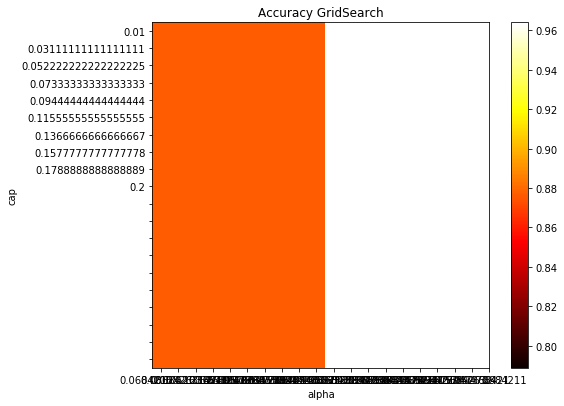

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
scores = grid_search.cv_results_['mean_test_score'].reshape(len(parameters2['alpha']),
                                                         len(parameters2['cap']))
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('alpha')
plt.ylabel('cap')
plt.colorbar()
plt.xticks(np.arange(len(parameters2['alpha'])), parameters2['alpha'])
plt.yticks(np.arange(len(parameters2['alpha'])), parameters2['cap'])
plt.title('Accuracy GridSearch')
plt.show()

In [7]:


# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'n_neighbors': [2,4,6,8,10],
    'metric':['euclidean', 'manhattan', 'cosine', 'l2']
}


parameters2 = {
    'clf__max_features': [50, 0.2, 0.3, 0.4,0.8, 'auto', 'log2'],
    'clf__bootstrap_feats': [True, False],
    'clf__n_estimators': [100,250,500],
    'clf__feat_importance':[mi, []]
}

# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', Knn_Forest(n_estimators=500, 
                       max_features=0.2, 
                       bootstrap_feats=False,
                       optim=False, 
                       parameters=parameters,
                       feat_importance=mi
                       )),
])

pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)

# grid_search = GridSearchCV(pipeline, parameters2, n_jobs=1, verbose=2)
# grid_search.fit(X_train, y_train)
# cur_mod = grid_search.best_estimator_
# pred = cur_mod.predict(X_test)

print(accuracy_score(y_test, pred))

/home/kostas/.local/lib/python2.7/site-packages/ipykernel_launcher.py:69: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(15676, 15676, 15676, 15676)
(15676, 15676, 15676)
500 ESTIMATORS -- 94.393
0.8511627906976744


In [128]:
np.array(mi).shape

(15285,)

In [107]:
if mi == []:
    feat_probas = [1/float(15285) for i in xrange(15285)]
else:
    feat_probas = mi/float(sum(mi))
print(feat_probas)

[3.66458532e-05 1.17863765e-04 2.08337729e-05 ... 7.93856492e-06
 1.04044869e-05 1.04044869e-05]


/home/kostas/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [89]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer
tr = TfidfVectorizer().fit_transform(X_train, y_train)
mi = mutual_info_classif(tr, y_train)

array([0.00434618, 0.01397857, 0.00247087, ..., 0.00094151, 0.00123397,
       0.00123397])

LR: 0.769515 (0.048411)
LDA: 0.773462 (0.051592)
KNN: 0.726555 (0.061821)
CART: 0.697847 (0.056063)
NB: 0.755178 (0.042766)
SVM: 0.651025 (0.072141)
DT: 0.697813 (0.059580)
RF: 0.755195 (0.075068)
LV: 0.760373 (0.058334)


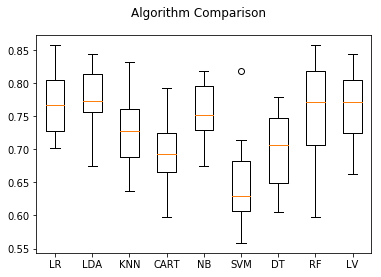

In [53]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
%matplotlib inline
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(random_state=42, n_estimators=100)))
models.append(('LV', Liquid_Voter(random_state=42, n_estimators=100)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
data loa

train time: 0.231s
test time:  0.003s
accuracy:   0.880



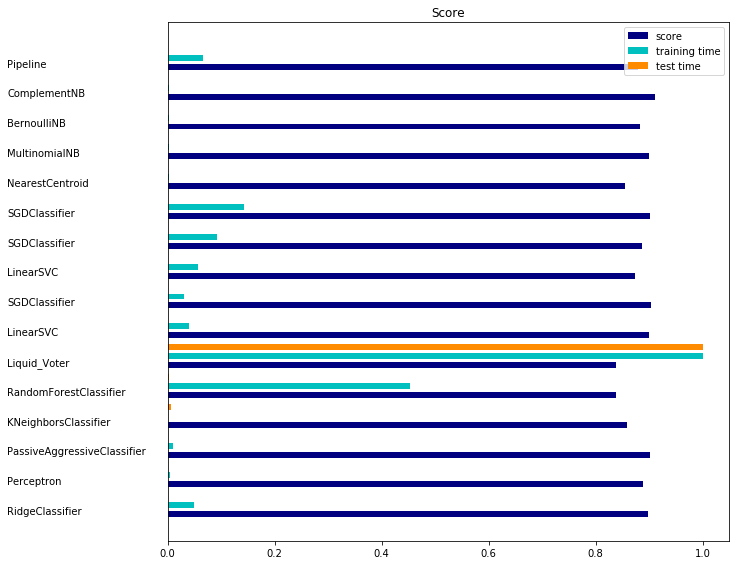

In [55]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')


# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()


# #############################################################################
# Load some categories from the training set
if opts.all_categories:
    categories = None
else:
    categories = [
        'alt.atheism',
        'talk.religion.misc',
        'comp.graphics',
        'sci.space',
    ]

if opts.filtered:
    remove = ('headers', 'footers', 'quotes')
else:
    remove = ()

print("Loading 20 newsgroups dataset for categories:")
print(categories if categories else "all")

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.target_names


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.data), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50, tol=1e-3), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50, tol=1e-3),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest"),
        (Liquid_Voter(n_estimators=100), "Liquid Voter")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()